In [12]:
import torch
import torch.nn as nn
# import pandas as pd

import sys
sys.path.append('../')
from HGP.models import LightModel
from GCN.models import LightModel as LightModel_GCN
import pickle

In [13]:
import networkx as nx

In [14]:
from utils.imports import *
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.profilers import SimpleProfiler

# BITTE EINMAL DEN MODELL NAMEN HIER EINMAL EINTRAGEN (HGP-SL o.ä.)

Damit die Datei unter dem Namen gespeichert wird

In [16]:
# %%
args_dict = take_hp("../log/emp-hgp-nci/emp-gcn-nci-grid001.yml")

# pl.seed_everything(args_dict["random_seed"], workers=True)


In [17]:
# %%
# Load the dataset
dataset = TUDataset(
    Path.cwd().joinpath("../data"),
    name=args_dict["dataset"],
    use_node_attr=True,
)
args_dict["num_classes"] = dataset.num_classes
args_dict["num_features"] = dataset.num_features

In [18]:
split_train = int(dataset.len() * args_dict["split_ratio"])
split_val = int((dataset.len() - split_train) * args_dict["test_ratio"])
split_test = dataset.len() - split_val - split_train

print(
    f"Hole: {dataset.len()}, Train: {split_train}, Val: {split_val}, Test: {split_test}"
)
# %%
train_data, eval_data, test_data = random_split(
    dataset,
    [split_train, split_val, split_test],
    generator=torch.Generator().manual_seed(42),
)

Hole: 4110, Train: 2055, Val: 1027, Test: 1028


In [19]:
# %%
train_loader = DataLoader(
    train_data,
    batch_size=args_dict["batch_size"],
    shuffle=False,
    num_workers=args_dict["num_workers"],
)
val_loader = DataLoader(
    eval_data,
    batch_size=args_dict["batch_size"],
    shuffle=False,
    num_workers=args_dict["num_workers"],
)
test_loader = DataLoader(
    test_data,
    batch_size= 1 ,# dataset.len() - split_test,
    shuffle=False,
    num_workers=args_dict["num_workers"],
)

In [24]:
# Loop over all models in the model/emp-enzym-equal folder
# and classify the graphs
loss = nn.CrossEntropyLoss(reduction="none")
softmax = nn.Softmax(dim=1)
Path(f"../analysis/{args_dict['architecture']}/{args_dict['dataset']}").mkdir(parents=True, exist_ok=True)

# Get model and config paths
model_paths = Path.cwd().joinpath("../model/emp-gcn-grid").iterdir()
log_paths = Path.cwd().joinpath("../log/emp-gcn").iterdir()

for i in range(54):
    # Load the config file
    args_dict = take_hp(f"../log/emp-gcn-nci/emp-gcn-nci-grid{i+1:03d}.yml")
    pl.seed_everything(args_dict["random_seed"], workers=True)

    # Load the model 
    model = LightModel_GCN(args_dict).to(args_dict["device"])
    model.eval()
    model.freeze()
    model.load_state_dict(torch.load(f"../model/emp-gcn-nci-grid/model_{i}.pt"))

    # Reset Variables
    graph_ids = []
    graphs = []
    counter = 0

    for batch in test_loader:
        data = batch.to(args_dict["device"])
        out = model(data)
        prediction_truth = np.argmax(softmax(out).detach().cpu().numpy()) == data.y.detach().cpu().numpy()
        
        graph_dict = {
            "model_id": f"{i}",
            "random_seed": f"{args_dict['random_seed']}",
            "dropout_ratio": f"{args_dict['dropout_ratio']}",
            "pooling_ratio": f"{args_dict['pooling_ratio']}",
            "structure_learning": f"{args_dict['structure_learning']}",	
            "graph_id": f"{counter}",
            "prediction": f"{np.argmax(softmax(out).detach().cpu().numpy())}",
            "label": f"{data.y.detach().cpu().numpy()[0]}",
            "correct": f"{prediction_truth[0]}",
            "softmax": nn.Softmax(dim=1)(out).detach().cpu().numpy()[0][data.y.detach().cpu().numpy()[0]],
            "sigmod": nn.Sigmoid()(out).detach().cpu().numpy()[0][data.y.detach().cpu().numpy()[0]],
            "loss": loss(out, data.y).detach().cpu().numpy()[0]
        }
        
        g = nx.from_edgelist(data.edge_index.cpu().numpy().T)
        g.graph.update(graph_dict)
        graphs.append(g)
        
        counter += 1
    
    np_graphs = np.array(graphs, dtype=object)
    np.save(f"../analysis/{args_dict['architecture']}/{args_dict['dataset']}/graphs_{i}.npy", np_graphs)

Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 2

LightModel(
  (model): Model(
    (conv1): GCNConv(37, 128)
    (conv2): GCN(128, 128)
    (conv3): GCN(128, 128)
    (pool1): SAGPool(GraphConv, 128, ratio=0.5, multiplier=1.0)
    (pool2): SAGPool(GraphConv, 128, ratio=0.5, multiplier=1.0)
    (lin1): Linear(in_features=256, out_features=128, bias=True)
    (lin2): Linear(in_features=128, out_features=64, bias=True)
    (lin3): Linear(in_features=64, out_features=2, bias=True)
  )
  (loss_fn): NLLLoss()
  (mcc): MatthewsCorrCoef()
  (f1): F1Score()
  (acc): Accuracy()
  (mcc_single): MatthewsCorrCoef()
  (f1_single): F1Score()
  (acc_single): Accuracy()
)

In [26]:
split_test

1028

In [27]:
test_loader = DataLoader(
    test_data,
    batch_size= 1028 ,# dataset.len() - split_test,
    shuffle=False,
    num_workers=args_dict["num_workers"],
)

In [35]:
from torchmetrics import F1Score, Precision, Recall, Accuracy

In [37]:
for batch in test_loader:
    data = batch.to(args_dict["device"])
    out = model(data)
    f1 = F1Score(num_classes=dataset.num_classes).to(args_dict["device"])(out, data.y)
    pr = Precision(num_classes=dataset.num_classes).to(args_dict["device"])(out, data.y)
    re = Recall(num_classes=dataset.num_classes).to(args_dict["device"])(out, data.y)
    ac = Accuracy(num_classes=dataset.num_classes).to(args_dict["device"])(out, data.y)
    print(f1, pr, re, ac)
    

tensor(0.6479, device='cuda:0') tensor(0.6479, device='cuda:0') tensor(0.6479, device='cuda:0') tensor(0.6479, device='cuda:0')


In [38]:
dataset.num_classes

2

In [51]:
# Loop over all models in the model/emp-enzym-equal folder
# and classify the graphs
Path(f"../analysis/{args_dict['architecture']}/{args_dict['dataset']}").mkdir(parents=True, exist_ok=True)

# Get model and config paths
model_paths = Path.cwd().joinpath("../model/emp-hgp-grid").iterdir()
log_paths = Path.cwd().joinpath("../log/emp-hgp").iterdir()

# numpy array to store the results
results = np.zeros((54, 5))

for i in range(54):
    # Load the config file
    args_dict = take_hp(f"../log/emp-hgp-nci/emp-hgp-nci-grid{i+1:03d}.yml")
    pl.seed_everything(args_dict["random_seed"], workers=True)

    # Load the model 
    model = LightModel(args_dict).to(args_dict["device"])
    model.eval()
    model.freeze()
    model.load_state_dict(torch.load(f"../model/emp-hgp-nci-grid/model_{i}.pt"))

    for batch in test_loader:

        data = batch.to(args_dict["device"])
        out = model(data)
        micro = F1Score(num_classes=dataset.num_classes, average="micro").to(args_dict["device"])(out, data.y)
        f1 = F1Score(num_classes=dataset.num_classes, average='macro').to(args_dict["device"])(out, data.y)
        pr = Precision(num_classes=dataset.num_classes, average='macro').to(args_dict["device"])(out, data.y)
        re = Recall(num_classes=dataset.num_classes, average='macro').to(args_dict["device"])(out, data.y)
        ac = Accuracy(num_classes=dataset.num_classes, average='macro').to(args_dict["device"])(out, data.y)

        results[i, 0] = f1
        results[i, 1] = pr
        results[i, 2] = re
        results[i, 3] = ac
        results[i, 4] = micro
    
np.save(f"../analysis/hgp_metrics.npy", results)

Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 21
Global seed set to 21
Global seed set to 1337
Global seed set to 1337
Global seed set to 2021
Global seed set to 2021
Global seed set to 2

In [52]:
np.random.choice(results[:,0], 3, replace=False)

array([0.69339848, 0.65948665, 0.70427006])

In [53]:
results[3,:]

array([0.64486605, 0.64844429, 0.64782709, 0.64782709, 0.64494163])

In [57]:
np.std(np.random.choice(results[:,0], 3, replace=False))

0.008678673818158468

In [60]:
import matplotlib.pyplot as plt

0.02069637636505519

In [68]:
#fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_data = np.zeros((54, 5, 2))
for i, point in enumerate(plot_data):

    sample_f1 = np.random.choice(results[:,0], i, replace=False)
    sample_pr = np.random.choice(results[:,1], i, replace=False)
    sample_re = np.random.choice(results[:,2], i, replace=False)
    sample_ac = np.random.choice(results[:,3], i, replace=False)
    sample_mi = np.random.choice(results[:,4], i, replace=False)

    plot_data[i, 0, 0] = np.mean(sample_f1)
    plot_data[i, 0, 1] = np.std(sample_f1)
    plot_data[i, 1, 0] = np.mean(sample_pr)
    plot_data[i, 1, 1] = np.std(sample_pr)
    plot_data[i, 2, 0] = np.mean(sample_re)
    plot_data[i, 2, 1] = np.std(sample_re)
    plot_data[i, 3, 0] = np.mean(sample_ac)
    plot_data[i, 3, 1] = np.std(sample_ac)
    plot_data[i, 4, 0] = np.mean(sample_mi)
    plot_data[i, 4, 1] = np.std(sample_mi)

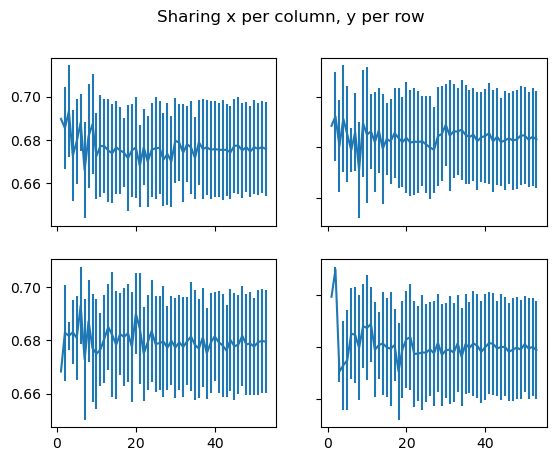

In [69]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(5, sharex=True, sharey=True)
fig.suptitle('Sharing x per column, y per row')
ax1.errorbar(np.arange(54), plot_data[:,0,0], yerr=plot_data[:,0,1])
ax2.errorbar(np.arange(54), plot_data[:,1,0], yerr=plot_data[:,1,1])
ax3.errorbar(np.arange(54), plot_data[:,2,0], yerr=plot_data[:,2,1])
ax4.errorbar(np.arange(54), plot_data[:,3,0], yerr=plot_data[:,3,1])
ax5.errorbar(np.arange(54), plot_data[:,4,0], yerr=plot_data[:,4,1])

for ax in fig.get_axes():
    ax.label_outer()

Text(0.5, 1.0, 'variable, symmetric error')

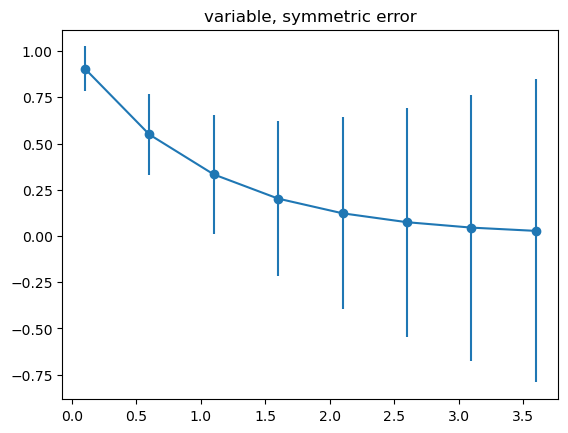

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)
# example error bar values that vary with x-position
error = 0.1 + 0.2 * x

fig, (ax0) = plt.subplots(nrows=1, sharex=True)
ax0.errorbar(x, y, yerr=error, fmt='-o')
ax0.set_title('variable, symmetric error')

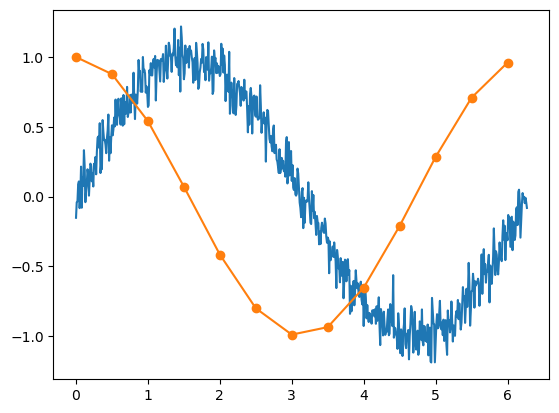

In [56]:
import matplotlib.pyplot as plt
import numpy as np


x1 = [x * 0.01 for x in range(0, 628)]
y1 = [np.sin(x * 0.01) + np.random.normal(0.0, 0.1) for x in range(0, 628)]

x2 = [x * 0.5 for x in range(0, round(63 / 5))]
y2 = [np.cos(x * 0.5) for x in range(0, round(63 / 5))]

plt.plot(x1, y1)
plt.plot(x2, y2, 'o-')

plt.show()  # doctest: +SKIP